<a href="https://colab.research.google.com/github/pouvelenc/DD2365-aflum/blob/main/adaptive_slip_NS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DD2365 - Project**
## **Adaptive algorithm for NS with slip-with-friction BCs**
**Povel Kann**

## **Environment setup**

In [21]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

import logging
logging.getLogger('FFC').setLevel(logging.CRITICAL)
logging.getLogger('UFL').setLevel(logging.CRITICAL)
logging.getLogger('DOLFIN').setLevel(logging.CRITICAL)

### **Mesh**

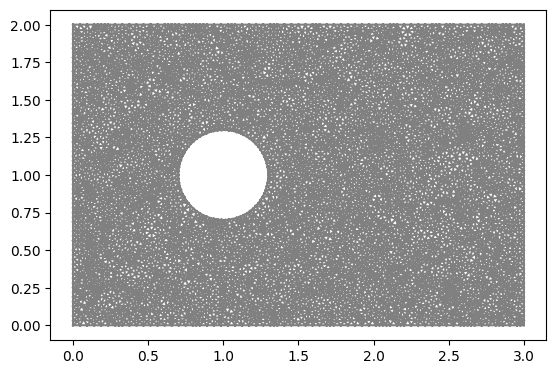

In [22]:
# Define rectangular domain
L = 3
H = 2

# Define circle
xc = 1
yc = 0.5*H
rc = 0.3

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

class Skin_Friction(SubDomain):
    def inside(self, x, on_boundary):
        return (on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) \
                and (not near(x[1], 0.0)) and (not near(x[1], H)))

left = Left()
right = Right()
lower = Lower()
upper = Upper()
skin_friction = Skin_Friction()

# Generate mesh
resolution = 64
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)
skin_friction.mark(boundaries, 5)

plt.figure()
plot(mesh)
plt.show()

## **Code**

#### **Plot over beta**

beta = 0.0


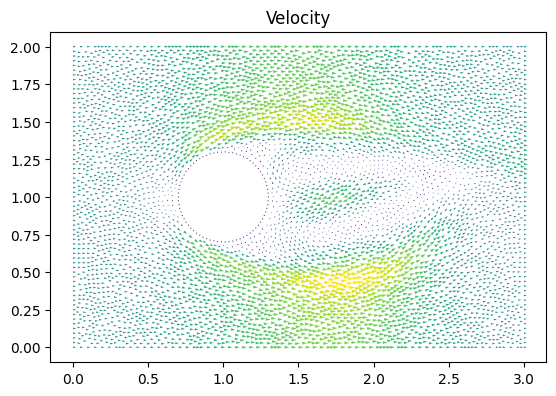

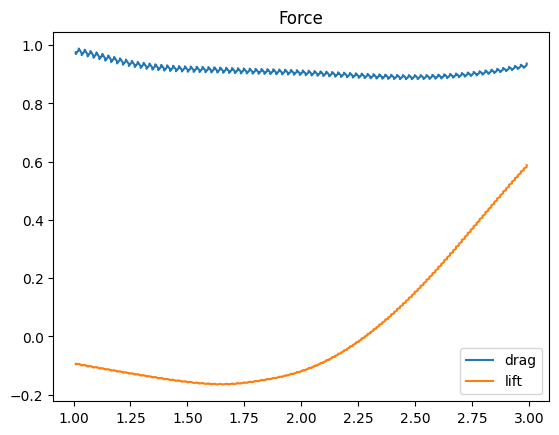

beta = 4.0


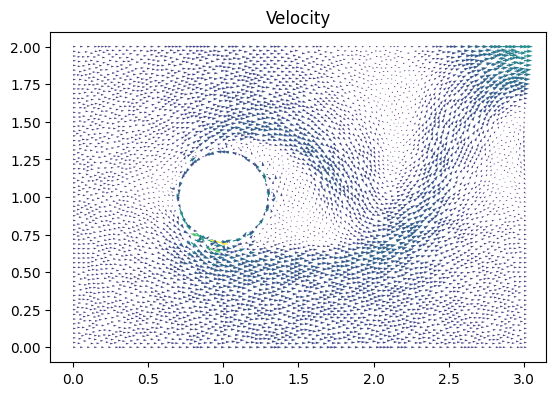

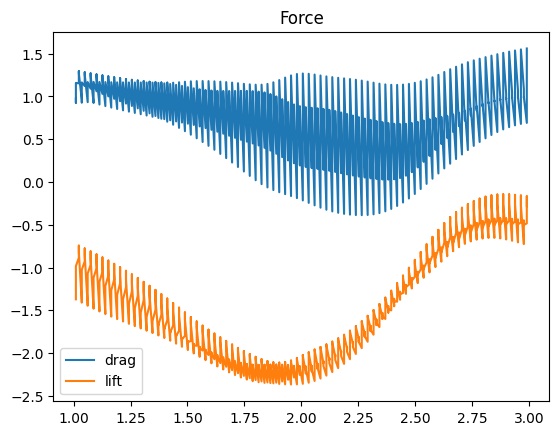

beta = 16.0


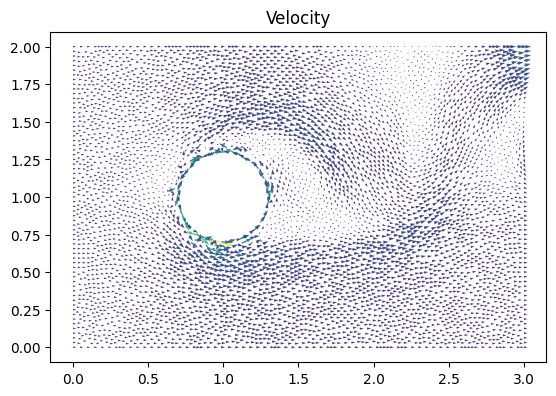

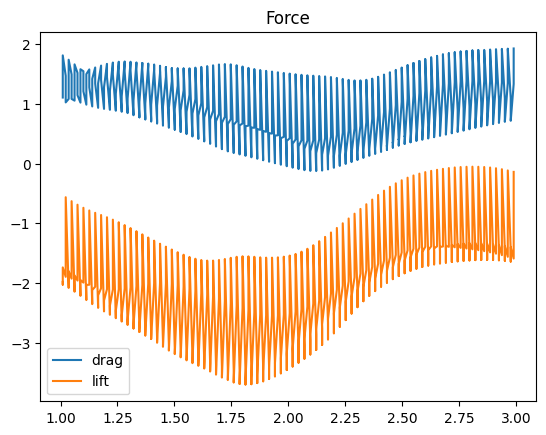

beta = 64.0


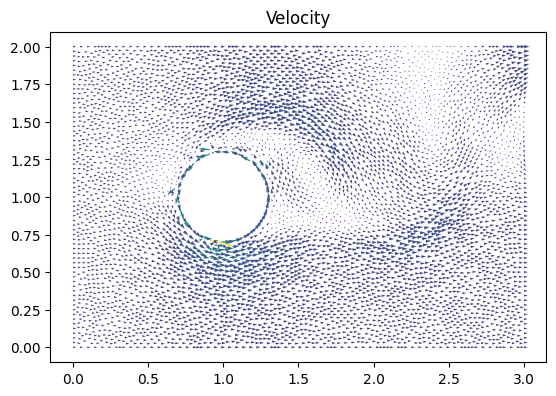

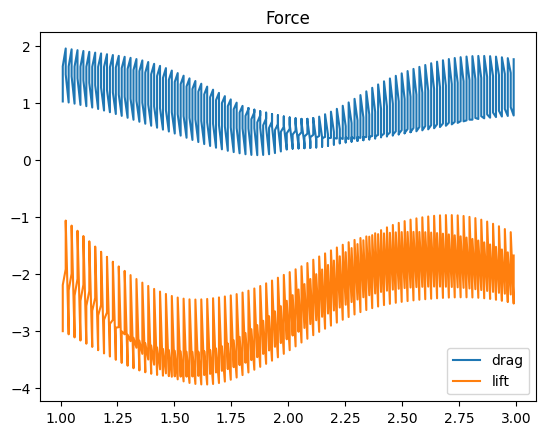

beta = 128.0


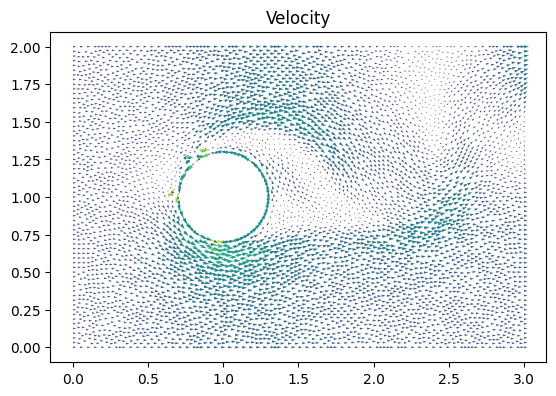

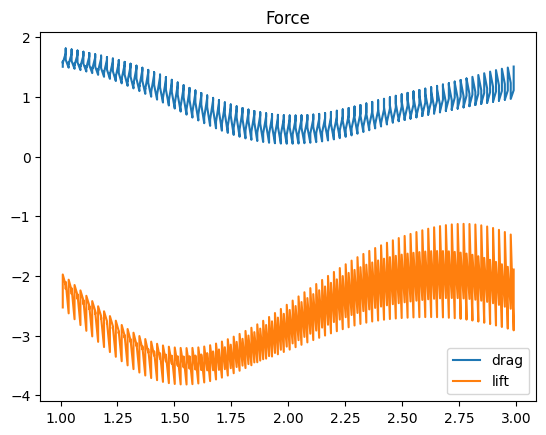

beta = 256.0


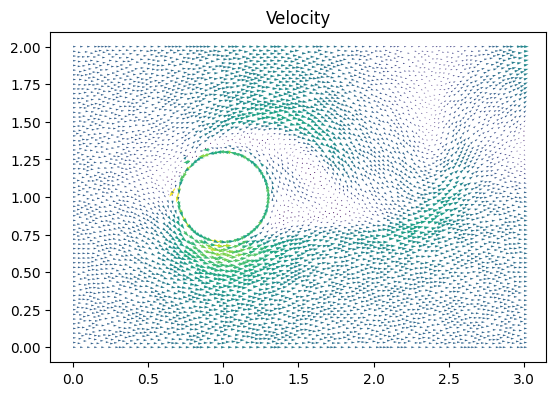

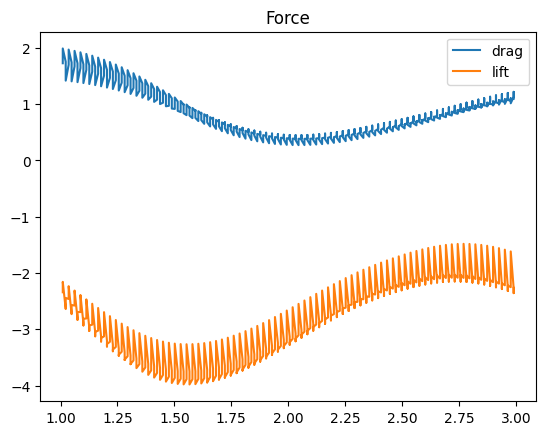

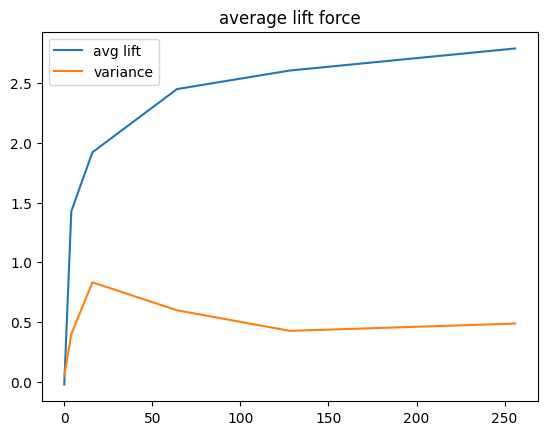

In [23]:
beta_list = [0.0, 4.0, 16.0, 64.0, 128.0, 256.0]
average_lift = []
variance_lift = []

for beta in beta_list:
  print(f'beta = {beta}')

  # Generate finite element spaces (for velocity and pressure)
  V = VectorFunctionSpace(mesh, "Lagrange", 1)
  Q = FunctionSpace(mesh, "Lagrange", 1)

  # Define trial and test functions
  u = TrialFunction(V)
  p = TrialFunction(Q)
  v = TestFunction(V)
  q = TestFunction(Q)


  # Define boundary conditions
  class DirichletBoundaryLower(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], 0.0)

  class DirichletBoundaryUpper(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], H)

  class DirichletBoundaryLeft(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], 0.0)

  class DirichletBoundaryRight(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], L)

  class DirichletBoundaryObjects(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

  dbc_lower = DirichletBoundaryLower()
  dbc_upper = DirichletBoundaryUpper()
  dbc_left = DirichletBoundaryLeft()
  dbc_right = DirichletBoundaryRight()
  dbc_objects = DirichletBoundaryObjects()

  uin = 1.0
  bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
  bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
  bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

  pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
  pout = 0.0
  bcp1 = DirichletBC(Q, pout, dbc_right)

  bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1]
  bcp = [bcp1]

  # Define measure for boundary integration
  ds = Measure('ds', domain=mesh, subdomain_data=boundaries)


  # Set viscosity
  nu = 1.0e-4


  # Define iteration functions
  # (u0,p0) solution from previous time step
  # (u1,p1) linearized solution at present time step
  u0 = Function(V)
  u1 = Function(V)
  p0 = Function(Q)
  p1 = Function(Q)

  # Set parameters for nonlinear and lienar solvers
  num_nnlin_iter = 5
  prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

  # Time step length
  dt = 0.5*mesh.hmin()


  # Define variational problem

  # Stabilization parameters
  h = CellDiameter(mesh);
  u_mag = sqrt(dot(u1,u1))
  d1 = 4.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
  d2 = 2.0*h*u_mag

  # slip-with-friction boundary conditions, implemented as penalty terms
  n = FacetNormal(mesh)
  t = as_vector([n[1], -n[0]])
  C_alpha = 1.0e2
  alpha = C_alpha/h
  omega = 1.0

  # angular (tangential) velocity
  u_t = 2.0

  # Smagorinsky model (simplified)
  C_t = 1.0e-2

  # Mean velocities for trapozoidal time stepping
  um = 0.5*(u + u0)
  um1 = 0.5*(u1 + u0)


  # Momentum variational equation on residual form
  Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx \
      - p1*div(v)*dx \
      + nu*inner(grad(um), grad(v))*dx \
      + C_t*h*h*sqrt(inner(grad(um1), grad(um1)))*inner(grad(um), grad(v))*dx \
      + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx \
      + d2*div(um)*div(v)*dx \
      + alpha*(inner(dot(um,n), dot(v,n)))*ds(5) \
      + beta*(inner(dot(um,t) - u_t, dot(v,t)))*ds(5)

  au = lhs(Fu)
  Lu = rhs(Fu)

  # Continuity variational equation on residual form
  Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
  ap = lhs(Fp)
  Lp = rhs(Fp)


  import scipy.linalg.lapack as la
  import numpy as np

  def triple_decomposition(grad_u):
      new_grad = np.array([[0,0,0],
                          [0,0,0],
                          [0,0,0]])
      for i in range(2):
        for j in range(2):
          new_grad[i,j] = grad_u[i,j]
      def dselect(arg1,arg2): return (arg2==0)
      T = la.dgees(dselect,new_grad,sort_t = 1)[0]
      sh = np.linalg.norm([T[0,1],T[0,2],T[1,2]+T[2,1]])
      el = np.linalg.norm(np.diag(T))
      rr = np.sqrt(2*min(abs(T[1,2]),abs(T[2,1]))**2)
      return sh, el, rr


  # Define the direction of the force to be computed
  phi_x_D = 1.0
  phi_y_D = 0.0
  phi_x_L = 0.0
  phi_y_L = 1.0

  #psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
  psi_expression_D = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x_D, phi_y=phi_y_D, element = V.ufl_element())
  psi_D = interpolate(psi_expression_D, V)

  psi_expression_L = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x_L, phi_y=phi_y_L, element = V.ufl_element())
  psi_L = interpolate(psi_expression_L, V)

  Force_D = inner((u1 - u0)/dt + grad(um1)*um1, psi_D)*dx - p1*div(psi_D)*dx + nu*inner(grad(um1), grad(psi_D))*dx
  Force_L = inner((u1 - u0)/dt + grad(um1)*um1, psi_L)*dx - p1*div(psi_L)*dx + nu*inner(grad(um1), grad(psi_L))*dx

  #plt.figure()
  #plot(psi, title="weight function psi")

  # Force normalization
  D = 2*rc
  normalization = -2.0/D

  # Force computation data
  force_array_D = np.array(0.0)
  force_array_D = np.delete(force_array_D, 0)
  force_array_L = np.array(0.0)
  force_array_L = np.delete(force_array_L, 0)
  time = np.array(0.0)
  time = np.delete(time, 0)
  start_sample_time = 1.0


  # Time stepping
  T = 3
  t = dt
  while t < T + DOLFIN_EPS:

      pin.t = t
      #uin.t = t

      # Solve non-linear problem
      k = 0
      while k < num_nnlin_iter:

          # Assemble momentum matrix and vector
          Au = assemble(au)
          bu = assemble(Lu)

          # Compute velocity solution
          [bc.apply(Au, bu) for bc in bcu]
          [bc.apply(u1.vector()) for bc in bcu]
          solve(Au, u1.vector(), bu, "bicgstab", "default")

          # Assemble continuity matrix and vector
          Ap = assemble(ap)
          bp = assemble(Lp)

          # Compute pressure solution
          [bc.apply(Ap, bp) for bc in bcp]
          [bc.apply(p1.vector()) for bc in bcp]
          solve(Ap, p1.vector(), bp, "bicgstab", prec)

          # Compute force
          F_D = assemble(Force_D)
          F_L = assemble(Force_L)
          if (t > start_sample_time):
            force_array_D = np.append(force_array_D, normalization*F_D)
            force_array_L = np.append(force_array_L, normalization*F_L)
            time = np.append(time, t)

          k += 1

      # Update time step
      u0.assign(u1)
      t += dt

  # Plot solution
  plt.figure()
  plot(u1, title="Velocity")

  plot_time += T/plot_freq

  plt.show()

  plt.figure()
  plt.title("Force")
  plt.plot(time, force_array_D, label="drag")
  plt.plot(time, force_array_L, label="lift")
  plt.legend()
  plt.show()

  average_lift.append(- np.mean(force_array_L))
  variance_lift.append(np.var(force_array_L))

plt.figure()
plt.title("average lift force")
plt.plot(beta_list, average_lift, label='avg lift')
plt.plot(beta_list, variance_lift, label='variance')
plt.legend()
plt.show()